In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.layers import Input, Dense, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [3]:
tf.keras.utils.set_random_seed(12)

batch_size = 32
img_height = img_width =224

In [4]:
directory = "/kaggle/input/pcos-detection-using-ultrasound-images/data/train"
test = "/kaggle/input/pcos-detection-using-ultrasound-images/data/test" 

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    #class_names=None,
    shuffle=True,
    seed=12,
    validation_split= 0.15,
    subset="training",
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1924 files belonging to 2 classes.
Using 1636 files for training.


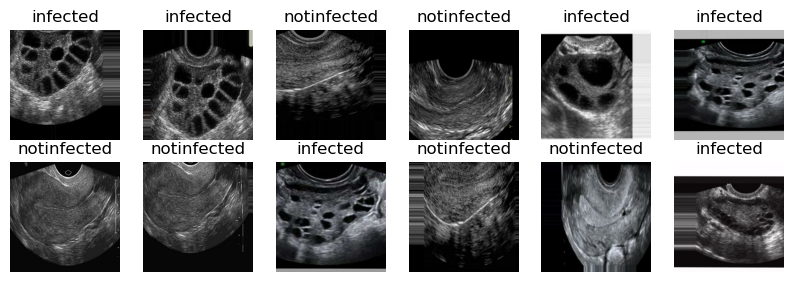

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(2):
    for i in range(12):
        ax = plt.subplot(6, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i])])
        plt.axis("off")

In [10]:
# data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale = 1./255,
                             shear_range = 0.2,
                             zoom_range = 0.2,
                             #width_shift_range=0.2,
                             #height_shift_range=0.2,
                             horizontal_flip = True,
                             vertical_flip=True,
                             rotation_range=20,
                             validation_split=0.2,
                             fill_mode='nearest'
                             )
# prepare an iterators for each dataset
train_ds = datagen.flow_from_directory(directory, 
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=batch_size,
                                       subset='training',
                                       seed=12)
# prepare an iterators for each dataset
val_ds = datagen.flow_from_directory( directory, 
                                       class_mode='categorical',
                                       classes=['infected', 'notinfected'],
                                       target_size=(224, 224),
                                       batch_size=batch_size,
                                       subset='validation',
                                       seed=12)

Found 1540 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [11]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test,
    seed=12,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1932 files belonging to 2 classes.


In [12]:
model = Sequential()

model.add(Conv2D(12, (5,5),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

model.add(Conv2D(8, (5,5),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(0.1))

model.add(Conv2D(4, (5,5),padding='SAME',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(2,activation='softmax'))

opt=Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=BinaryCrossentropy(), metrics=['accuracy'])

In [14]:
earlyStopping = EarlyStopping(monitor="val_loss", mode="min", verbose=1,patience=15)

In [15]:
history = model.fit( 
    train_ds,
    validation_data=val_ds,
    callbacks=[earlyStopping],
    batch_size=batch_size,
    verbose=1,
    epochs=20)

Epoch 1/20
49/49 [==============================] - 36s 713ms/step - loss: 0.3529 - accuracy: 0.8390 - val_loss: 0.2155 - val_accuracy: 0.9219
Epoch 2/20
49/49 [==============================] - 23s 461ms/step - loss: 0.4718 - accuracy: 0.8195 - val_loss: 0.3160 - val_accuracy: 0.9479
Epoch 3/20
49/49 [==============================] - 23s 471ms/step - loss: 0.2275 - accuracy: 0.9305 - val_loss: 0.2131 - val_accuracy: 0.9453
Epoch 4/20
49/49 [==============================] - 23s 476ms/step - loss: 0.1411 - accuracy: 0.9610 - val_loss: 0.1255 - val_accuracy: 0.9531
Epoch 5/20
49/49 [==============================] - 23s 468ms/step - loss: 0.1386 - accuracy: 0.9623 - val_loss: 0.1249 - val_accuracy: 0.9818
Epoch 6/20
49/49 [==============================] - 23s 466ms/step - loss: 0.0821 - accuracy: 0.9799 - val_loss: 0.1198 - val_accuracy: 0.9609
Epoch 7/20
49/49 [==============================] - 23s 461ms/step - loss: 0.0792 - accuracy: 0.9714 - val_loss: 0.1133 - val_accuracy: 0.9609

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, None, None, 12)    912       
                                                                 
 max_pooling2d (MaxPooling2D  (None, None, None, 12)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 8)     2408      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, None, None, 8)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 4)     804       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, None, None, 4)    0

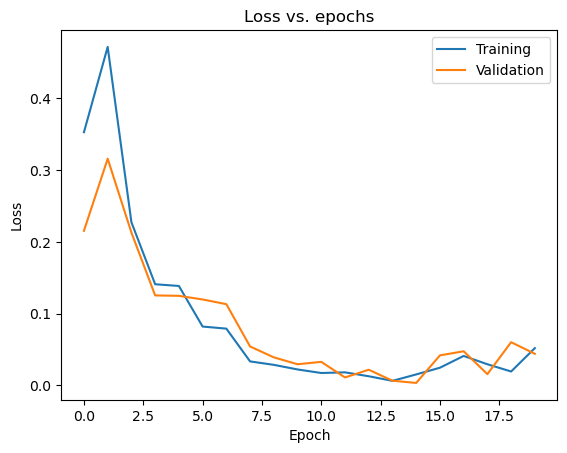

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

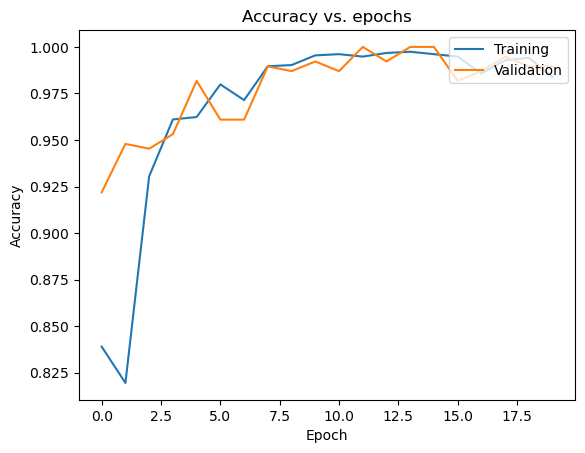

In [18]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [21]:
model.evaluate(val_ds)

12/12 [==============================] - 5s 381ms/step - loss: 0.0360 - accuracy: 0.9948


[0.036010295152664185, 0.9947916865348816]

In [ ]:
model.save('model.h5')